In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pack_padded_sequence
from torch.utils.tensorboard import SummaryWriter

import torchvision
from torchvision.transforms import transforms
from torchvision.datasets import CocoCaptions

import os
import pickle
from PIL import Image
from pycocotools.coco import COCO
import matplotlib.pyplot as plt

import nltk
from nltk.tokenize import word_tokenize

nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/rishab/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Define paths 

In [2]:
# Define paths 
train_captions_file = 'archive/captions/annotations/captions_train2014.json'
val_captions_file = 'archive/captions/annotations/captions_val2014.json'
train_image_dir = 'archive/images/train2014'
val_image_dir = 'archive/images/val2014'
vocab_path = 'vocab/vocab.pickle'
checkpoint_path = 'models/checkpoints/'

# Custom Dataset for COCO &#x1F4C1;
---
We define a custom PyTorch dataset for COCO dataset.<br>
The custom dataset returns (image, caption) pair which helps in training both the Encoder and Decoder easily.


## References &#x1F4DA; 
---
+ [pytorch-tutorial](https://github.com/yunjey/pytorch-tutorial/blob/master/tutorials/03-advanced/image_captioning/data_loader.py) - Explains the details of building a custom dataset for image captioning
+ [pycocoDemo Notebook](https://github.com/cocodataset/cocoapi/blob/master/PythonAPI/pycocoDemo.ipynb) - Explains the details of COCO API

In [3]:
class COCODataset(Dataset):
    """
    Define a custom dataset for your dataloader.
    """
    
    def __init__(self, root, annFile, Dictionary, transform=None):
        """
        Args:
            root: image directory.
            annFile: path to captions json file.
            Dicationary: Object that maps words to a unique number 
            transform: transforms on images.
        """
        self.root = root
        self.coco = COCO(annFile) 
        self.ids = list(self.coco.anns.keys()) # Extract ids of captions from the anns dict.
        self.Dictionary = Dictionary
        self.transform = transform
    
    def __getitem__(self, index):
        """
        Index through the dataset.
        Returns a data pair (image, captions).
        
        coco.anns is a dictionary.
        keys: Elements of ids.
        value: Dictionary with keys 'image_id', 'id' and 'caption'.
        
        coco.LoadImgs is a method.
        parameter passed: image_id.
        return: a list of dictionaries for that image_id.
        """
        Dictionary = self.Dictionary
        coco = self.coco
        ids = self.ids
        
        # Extract the caption from self.coco object.
        ann_id = ids[index]
        caption = coco.anns[ann_id]['caption'] # Extract caption using ann_id from ann dict.
        img_id = coco.anns[ann_id]['image_id'] # Extract image id from ann dict.
        
        # Calculate path variable using img_id and use it to extract each jpg.
        path = coco.loadImgs(img_id)[0]['file_name']
        
        # Read image and use transform
        image = Image.open(os.path.join(self.root, path)).convert('RGB')
        if self.transform is not None:
            image = self.transform(image)
            
        # Tokenize the caption and add <start> and <end> tokens.
        # nltk provides a more powerful tokenizer compared to torchtext.
        tokens = nltk.tokenize.word_tokenize(str(caption).lower())
        caption = []
        
        # vocab(token) return a one hot vector for the corresponding word.
        caption.append(Dictionary('<start>'))
        caption.extend([Dictionary(token) for token in tokens])
        caption.append(Dictionary('<end>'))
        label = torch.tensor(caption).long()
            
        return image, label
    
    def __len__(self):
        return(len(self.ids))
        

In [4]:
class Vocabulary():
    """
    A Vocabulary wrapper class for building word Dictionary. 
    It helps convert a word to an index(scalar value).
    It also has an index to word mapping.
    """
    def __init__(self):
        self.word2idx = {}
        self.idx2word = {}
        self.idx = 0

    def add_word(self, word):
        if not word in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            self.idx += 1
    
    def __call__(self, word):
        if not word in self.word2idx:
            return self.word2idx['<unk>']
        
        return self.word2idx[word]
        
    def __len__(self):
        return len(self.word2idx)

In [5]:
def build_vocabulary(ann_file):
    """
    Build the Dictionary using the functionality of the Vocabulary wrapper.
    """
    coco = COCO(ann_file)
    ids = coco.anns.keys()
    
    word_list = []
    for i, id in enumerate(ids):
        caption = str(coco.anns[id]['caption'])
        tokens = nltk.tokenize.word_tokenize(caption.lower())
        
        # Create a list of all the words present in the dataset
        words = [word for word in tokens]
        word_list.extend(words)
        
        if (i+1) % 1000 == 0:
            print(f"[{i + 1}/{len(ids)}] Tokenized the captions.")
    
    vocab = Vocabulary()
    vocab.add_word('<pad>')
    vocab.add_word('<start>')
    vocab.add_word('<end>')
    vocab.add_word('<unk>')

    # Add the words to the vocabulary.
    for i, word in enumerate(word_list):
        vocab.add_word(word)
    
    return vocab

In [6]:
def collate_fn(samples):
    """
    We use a custom collate_fn to combine a tuple (image, caption) into a mini-batch. 
    We can combine the captions by padding them to be of similar length.
    """
    images = [sample[0] for sample in samples]
    images = torch.stack(images, 0)
    
    # Pad captions to a consistent length.
    # This function also adds the batch dimension to captions.
    captions = [sample[1] for sample in samples]
    captions = torch.nn.utils.rnn.pad_sequence(captions, batch_first=True)
    
    # We need lengths of the captions to unpad using pack_padded_sequences.
    lengths = [len(caption) for caption in captions]
    
    return images, captions, lengths

In [7]:
# Save the Vocabulary object as a pickle file.
# Uncomment to save the pickle file for the first time.
# vocab = build_vocabulary(train_captions_file)
# with open(vocab_path, 'wb') as f:
#     pickle.dump(vocab, f)

In [8]:
# Apply a series of Augmentations to data.
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the image to 224x224
    transforms.ToTensor(),  # Convert the image to a tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize the image
])

visualization_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the image to 224x224
    transforms.ToTensor()  # Convert the image to a tensor
])

# Load the Vocabulary object from the pickle file.
with open(vocab_path, 'rb') as file:
    vocab = pickle.load(file)

# Define Batch Size for your dataloader.
batch_size = 32

visualization_dataset = CocoCaptions(root=train_image_dir, annFile=train_captions_file, transform=visualization_transform)
visualization_dataloader = DataLoader(visualization_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

train_dataset = COCODataset(root=train_image_dir, annFile=train_captions_file, Dictionary=vocab, transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

val_dataset = COCODataset(root=val_image_dir, annFile=val_captions_file, Dictionary=vocab, transform=visualization_transform)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

loading annotations into memory...
Done (t=0.51s)
creating index...
index created!
loading annotations into memory...
Done (t=0.58s)
creating index...
index created!
loading annotations into memory...
Done (t=0.26s)
creating index...
index created!


In [9]:
print(f'The batch size = {batch_size}')
print(f'The number of batches in your dataloader = {len(train_dataloader)}')
print(f'Image Shape = {train_dataset[0][0].shape}')
print(f'Caption Shape = {next(iter(train_dataloader))[1][4].shape}')

The batch size = 32
The number of batches in your dataloader = 12942
Image Shape = torch.Size([3, 224, 224])
Caption Shape = torch.Size([19])


In [10]:
# A sample label from the training dataset after tokenization.
print("A sample caption from the training dataset after tokenization:")
print([vocab.idx2word[idx] for idx in next(iter(train_dataloader))[1][0].tolist()])

# A sample label from the training dataset after assigning indices to words.
print("\nA sample caption from the training dataset after assigning indices to words")
print([idx for idx in next(iter(train_dataloader))[1][0].tolist()])

A sample caption from the training dataset after tokenization:
['<start>', 'a', 'very', 'clean', 'and', 'well', 'decorated', 'empty', 'bathroom', '<end>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']

A sample caption from the training dataset after assigning indices to words
[1, 4, 5, 6, 7, 8, 9, 10, 11, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0]


# We Visualize our data from COCO dataset including the captions

1. Closeup of bins of food that include broccoli and bread.
2. A giraffe eating food from the top of the tree.
3. A flower vase is sitting on a porch stand.
4. A zebra grazing on lush green grass in a field.
5. Woman in swim suit holding parasol on sunny day.
6. A couple of men riding horses on top of a green field.
7. They are brave for riding in the jungle on those elephants.
8. a black and silver clock tower at an intersection near a tree
9. A train coming to a stop on the tracks out side.


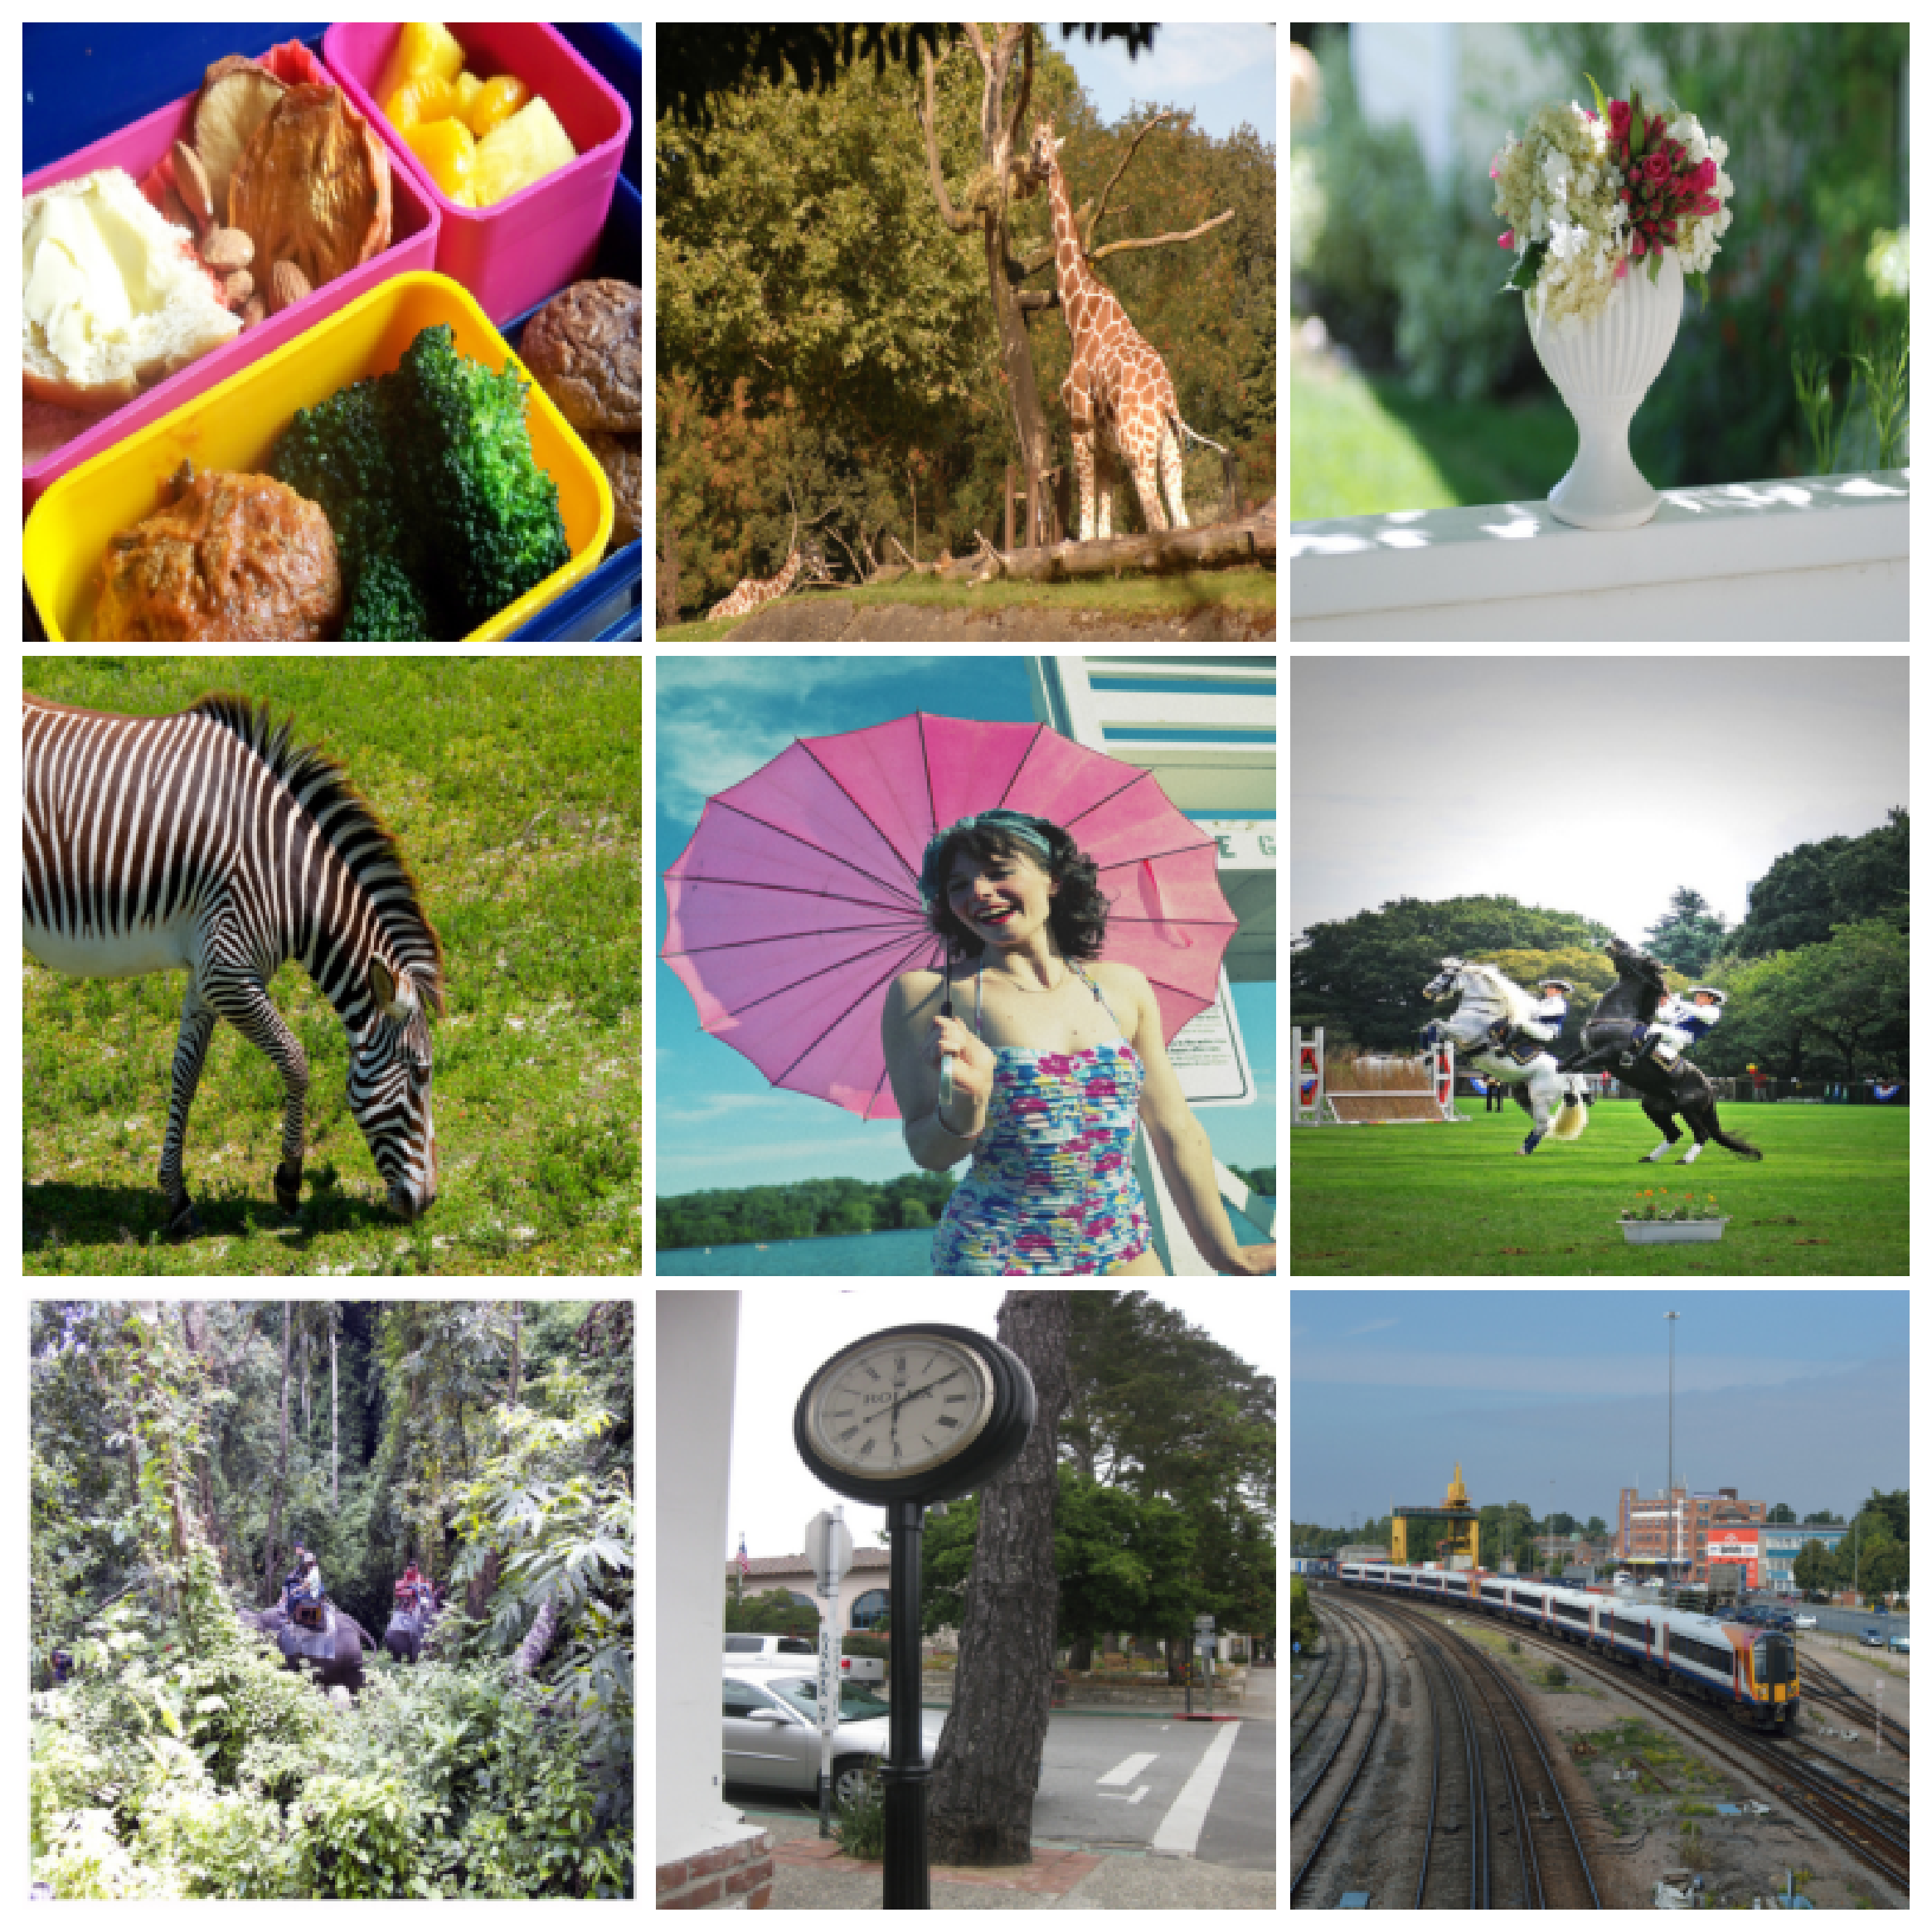

In [11]:
# Extract captions and images from the dataset.
captions = [visualization_dataset[i][1][0] for i in range(9)]
images = [visualization_dataset[i][0] for i in range(9)]

# Create grid of shape 9 * 9.
grid_image = torchvision.utils.make_grid(images, nrow=3, padding=5, pad_value=1)

# Iterate through the captions of the images.
for idx, caption in enumerate(captions):
    print(f'{idx + 1}. '+caption)

# Display the grid with 9 images.
plt.figure(figsize=(30, 30))
plt.imshow(grid_image.permute(1, 2, 0)) # Convert image from CWH to HWC format for matplotlib.
plt.axis('off')
plt.show()

# The Model

In [12]:
class ImageEncoderCNN(nn.Module):
    """
    The CNN encoder learns the features of the image and returns a feature vector.
    The feature vector will be used to train the decoder LSTM network.
    """

    def __init__(self, embed_size):
        super(ImageEncoderCNN, self).__init__()

        # Load Pretrained ResNet152 model.
        resnet = torchvision.models.resnet152(weights='ResNet152_Weights.DEFAULT')

        # Delete the last fc Layer (Classfication Head) from ResNet. We are not performing Classification.
        modules = list(resnet.children())[:-1] # delete the last fc layer.
        self.resnet = nn.Sequential(*modules) 
        self.encode = nn.Linear(in_features=resnet.fc.in_features, out_features=embed_size) 
        self.bn = nn.BatchNorm1d(embed_size, momentum=0.01)
        
    def forward(self, images):
        """
        Forward propagation.
        Resnet -> Linear -> Batch Normalization (1D).
        """
        # We do not train the resnet layers. We use pretrained weights.
        with torch.no_grad():
            resnet_output = self.resnet(images) # output size => [batch_size, 2048, 1, 1].
        
        resnet_output = resnet_output.reshape(resnet_output.size(0), -1) # output size => [batch_size, 2048].
        encoding = self.encode(resnet_output) # output size => [batch_size, embed_size] vector.
        normalized_encoding = self.bn(encoding)
        
        return normalized_encoding

In [13]:
class CaptionDecoderLSTM(nn.Module):
    """
    The LSTM decoder takes in the encoded image vector.
    It returns a sequence, which is the caption describing the image.
    """

    def __init__(self, vocab_size, embed_dim, hidden_size, num_layers):
        super(CaptionDecoderLSTM, self).__init__()
        
        self.embed = nn.Embedding(vocab_size, embed_dim) 
        self.lstm = nn.LSTM(embed_dim, hidden_size, num_layers, batch_first=True)
        self.output_layer = nn.Linear(hidden_size, vocab_size) # compute the logits for passing it to softmax.

    def forward(self, encoded_image, caption, lengths):
        # Pass in the captions as a tensor of indices.
        embeddings = self.embed(caption[:, :-1]) # output size => [batch_size, sequence_length, embed_dim].
        
        # Concatenate caption embeddings with the encoded image.
        embeddings_with_image = torch.cat((encoded_image.unsqueeze(1), embeddings), dim=1)
        
        # Packed data 
        packed = pack_padded_sequence(embeddings_with_image, lengths, batch_first=True)
        
        output, _ = self.lstm(packed) 
        output_logits = self.output_layer(output.data) 
        
        return output_logits
    
    def generate_caption(self, encoded_image, max_seq_length):
        """
        Use greedy search to generate captions during inference.
        """
        with torch.no_grad():
            caption = []
            states = None
            lstm_input = encoded_image.unsqueeze(1)            
            
            # Predict one word in each iteration.
            for i in range(max_seq_length):
                # Compute the logits with the output of the lstm.
                output, states = self.lstm(lstm_input, states) 
                output = self.output_layer(output.squeeze(1))
                
                # Softmax gives the probability distribution over the whole vocabulary.
                # Pick the most probable word (greedy search)
                output = F.softmax(output, dim=1)
                predicted  = output.argmax(1)
                caption.append(predicted.item())
                
                if vocab.idx2word[predicted.item()] == '<end>':
                    break
                
                # Compute the embedding of the current predicted word for the next layer.
                lstm_input = self.embed(predicted).unsqueeze(1)

            return caption

# Model Training

In [14]:
embed_size = 256
hidden_size = 512
num_layers = 1
vocab_size = len(vocab)
log_step = 10
total_steps = len(train_dataloader)
save_step = 1000

# Device configuration.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

encoder = ImageEncoderCNN(embed_size).to(device)
decoder = CaptionDecoderLSTM(vocab_size, embed_size, hidden_size, num_layers).to(device)

In [15]:
# Hyperparameters
num_epochs = 100
learning_rate = 0.001

criterion = nn.CrossEntropyLoss()
# Exclude the parameters of resnet152 in Adam.
params = list(decoder.parameters()) + list(encoder.encode.parameters()) + list(encoder.bn.parameters())
optimizer = torch.optim.Adam(params, lr=learning_rate)

In [16]:
import gc

start_at_checkpoint = True # Boolean storing whether you want to start at a checkpoint.
start_epoch = 1
writer = SummaryWriter("runs/coco")
step = 0
running_loss = 0.0

if(start_at_checkpoint):
    start_epoch = 12 # The start epoch of the model you want to load.
    resume_epoch = start_epoch-1
    
    # Load the model weights from the checkpoint.
    encoder_checkpoint = torch.load(os.path.join(
            checkpoint_path, f'encoder-{resume_epoch}.pth'))

    decoder_checkpoint = torch.load(os.path.join(
            checkpoint_path, f'decoder-{resume_epoch}.pth'))

    encoder.load_state_dict(encoder_checkpoint['model_state_dict'])
    decoder.load_state_dict(decoder_checkpoint['model_state_dict'])
    optimizer.load_state_dict(decoder_checkpoint['optimizer_state_dict'])

# Training loop
for epoch in range(num_epochs-start_epoch+1):
    for i, (images, captions, lengths) in enumerate(train_dataloader):
        # torch.cuda.empty_cache()
        
        # # Uncomment to track GPU memory usage.
        # allocated_memory = torch.cuda.memory_allocated()
        # print(f"Currently allocated GPU memory: {allocated_memory / (1024**3):.2f} GB")
        
        # Pass the data to the GPU.
        images = images.to(device)
        captions = captions.to(device)

        # Run forward propagation.
        encoded_image = encoder(images)
        caption_outputs = decoder(encoded_image, captions, lengths)
        caption_targets = pack_padded_sequence(captions, lengths, batch_first=True).data

        # Compute the model loss.
        loss = criterion(caption_outputs, caption_targets)
        running_loss += loss.item()

        # Don't accumulate gradients.
        encoder.zero_grad()
        decoder.zero_grad()

        # Run Backpropagation and take a step down the loss landscape.
        loss.backward()
        optimizer.step()
        
        gc.collect()
        
        # Information to track the training process.
        if i % log_step == 0:
            print(f'Epoch [{epoch+start_epoch}/{num_epochs}], Step [{i}/{total_steps}], Loss: { loss.item():.4f}')
            # Log metrics to Tensorboard.
            writer.add_scalar("Training loss", running_loss/log_step, global_step=step)
            step += 1
            running_loss = 0.0

    # Create checkpoints in training.
    encoder_checkpoint = {
        'model_state_dict': encoder.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }

    torch.save(encoder_checkpoint, os.path.join(
        checkpoint_path, f'encoder-{epoch+start_epoch}.pth'))

    decoder_checkpoint = {
        'model_state_dict': decoder.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }

    torch.save(decoder_checkpoint, os.path.join(
        checkpoint_path, f'decoder-{epoch+start_epoch}.pth'))

# Run Inference

In [17]:
encoder = ImageEncoderCNN(embed_size).eval().to(device) # Eval because batch norm uses moving average.
decoder = CaptionDecoderLSTM(vocab_size, embed_size, hidden_size, num_layers).to(device)

# Load the model weights for inference.
inference_epoch = 11 # epoch number of the model whose weights you want to use for inference.
encoder_checkpoint = torch.load(os.path.join(
            checkpoint_path, f'encoder-{inference_epoch}.pth'))

decoder_checkpoint = torch.load(os.path.join(
            checkpoint_path, f'decoder-{inference_epoch}.pth'))

# Load the weights into the model.
encoder.load_state_dict(encoder_checkpoint['model_state_dict'])
decoder.load_state_dict(decoder_checkpoint['model_state_dict'])

<All keys matched successfully>

In [18]:
def postprocess_caption(caption):
    """
    Convert the caption with indices to human readable form.
    """
    sampled_caption_tokens = [vocab.idx2word[word_idx] for word_idx in caption]
    sampled_caption = ' '.join(sampled_caption_tokens)
    return sampled_caption

In [19]:
def print_caption(element_number):
    max_seq_length = 20

    image = val_dataset[element_number][0]
    caption = val_dataset[element_number][1]
    image = image.to(device)

    # Pass image through the model
    image_features = encoder(image.unsqueeze(0))

    # Generate caption
    caption_pred = decoder.generate_caption(image_features, max_seq_length)  

    # Post-process generated and reference captions
    caption_pred = postprocess_caption(caption_pred)   
    caption = postprocess_caption(caption.tolist())
    return caption_pred, caption
    
def print_image(image_ids):
    # Extract images from the dataset.
    images = [val_dataset[i][0] for i in image_ids]

    # Create grid of shape 9 * 9.
    grid_image = torchvision.utils.make_grid(images, nrow=3, padding=5, pad_value=1)

    # Display the grid with 9 images.
    plt.figure(figsize=(30, 30))
    plt.imshow(grid_image.permute(1, 2, 0)) # Convert image from CWH to HWC format for matplotlib.
    plt.axis('off')
    plt.show()

The predicted captions:
<start> a large airplane flying high up in the air . <end>
<start> a little girl sitting on a bench in the grass <end>
<start> a computer and telephone control connected to a bench . <end>
<start> a bathroom with a toilet and a sink <end>
<start> a group of people walking across a field <end>
<start> a white plane is parked on a runway . <end>
<start> a red and white numbered motorcycle is parked in a parking lot . <end>
<start> a cat is standing on a toilet seat . <end>
<start> a group of people standing around a plane . <end>

The reference captions from the dataset:
<start> a large white airplane flying through the sky . <end>
<start> a small child lies on a bench , holding a plastic snacks bag . <end>
<start> the computer desk in the corner is by a window . <end>
<start> a bathroom with a mirror , lighting and bathtub with shower combo <end>
<start> an old picture of a family on their farm . <end>
<start> an egyptian airlines plane landing at an airport . <e

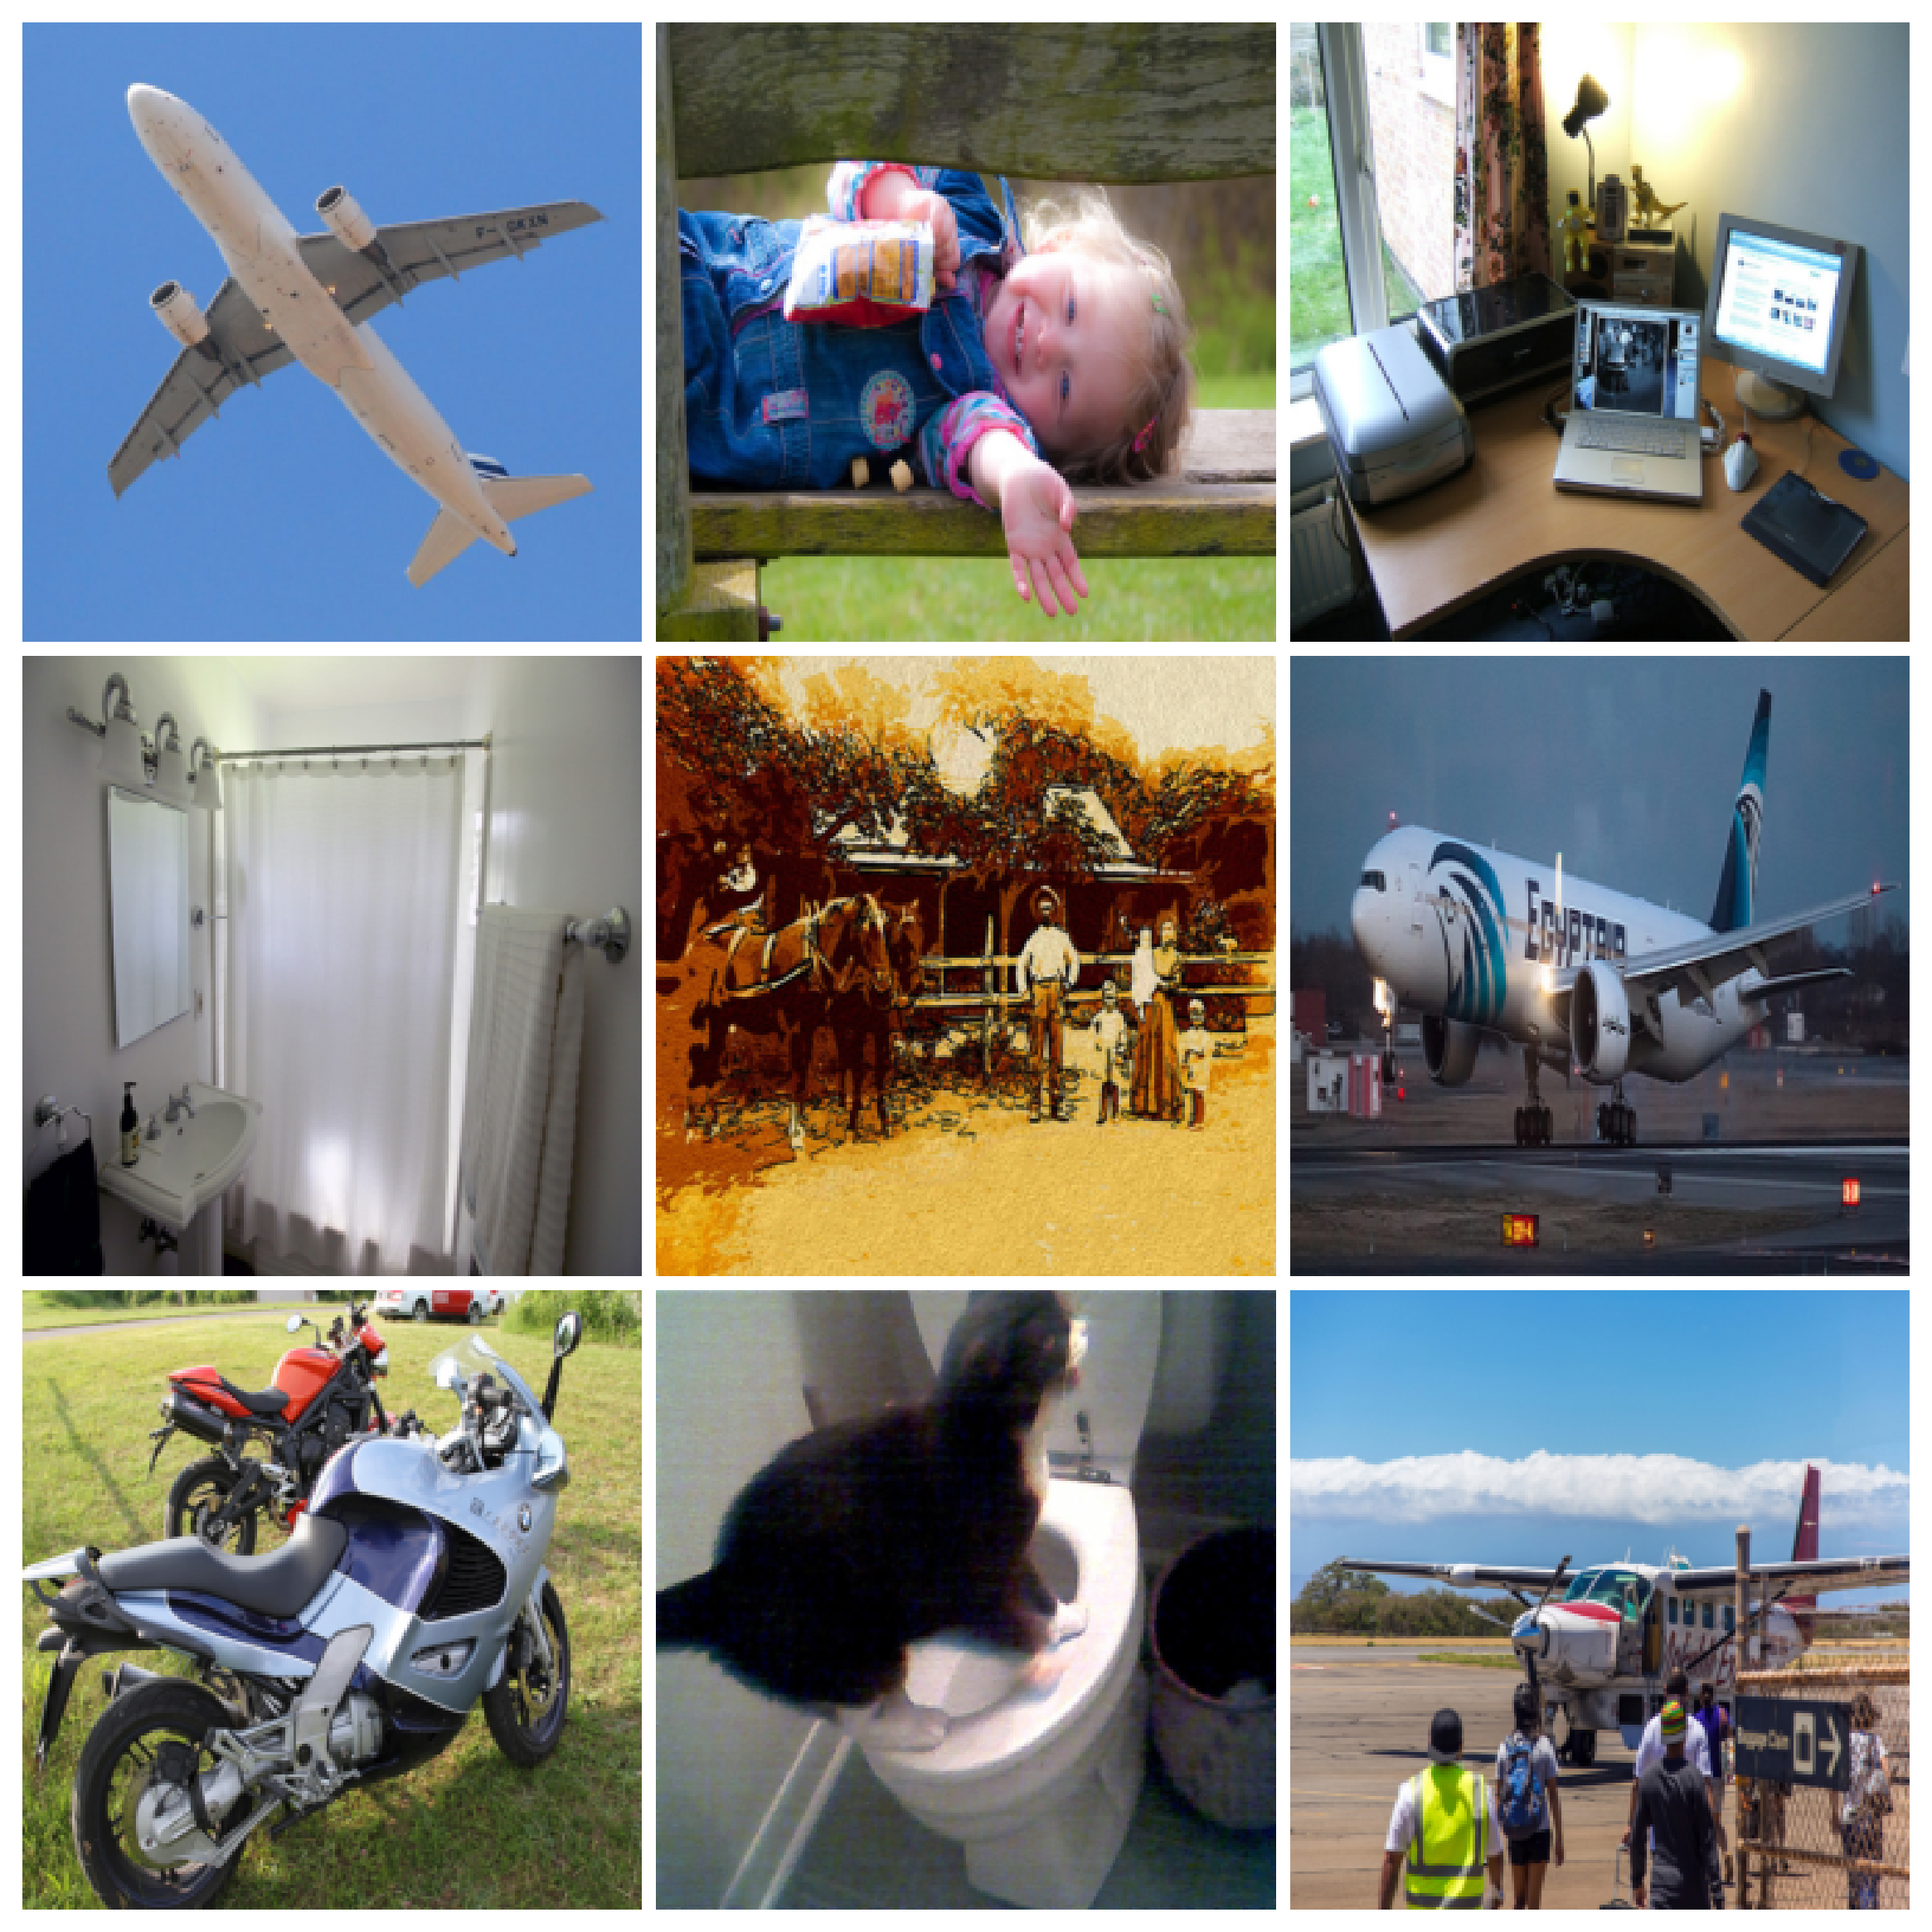

In [20]:
# List of image id's to print.
image_ids = [2544, 2582, 264, 1000, 1245, 980, 3401, 1234, 837]

# Print the captions and the corresponding images in a grid format.
print('The predicted captions:')
for image_id in image_ids:
    (caption_prediction, _) = print_caption(image_id)
    print(caption_prediction)
    
print('\nThe reference captions from the dataset:')
for image_id in image_ids:
    (_, caption_ref) = print_caption(image_id)
    print(caption_ref)
    
print_image(image_ids)

In [21]:
from nltk.translate.bleu_score import corpus_bleu
from nltk.tokenize import word_tokenize
from tqdm import tqdm

def evaluate(encoder, decoder, val_dataset):
    encoder.eval()
    max_seq_length = 20
    generated_captions = []
    reference_captions = []
    val_size = 1000 # Number of elements of validation dataset used to validate.
    smaller_val_dataset = [val_dataset[i] for i in range(val_size)]
    
    for image, caption in tqdm(smaller_val_dataset):
        image = image.to(device)
        # Pass image through the model
        image_features = encoder(image.unsqueeze(0))
        caption_pred = decoder.generate_caption(image_features, max_seq_length)  

        # Post-process generated and reference captions
        caption_pred = postprocess_caption(caption_pred)  
        caption_ref = postprocess_caption(caption.tolist())  
        
        # Tokenize captions
        caption_pred_tokens = word_tokenize(caption_pred)
        caption_ref_tokens = word_tokenize(caption_ref)
        
        # Collect generated and reference captions
        generated_captions.append(caption_pred_tokens)
        reference_captions.append([caption_ref_tokens])

    # Calculate BLEU score
    bleu_score = corpus_bleu(reference_captions, generated_captions)

    return bleu_score


In [22]:
bleu_score = evaluate(encoder, decoder, val_dataset)
print(f'The bleu score = {bleu_score}')

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:26<00:00, 37.85it/s]


The bleu score = 0.2759533957732755
